# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS
from src.logging import get_logger

logger = get_logger(__name__)

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [3]:
# Generate markets and prices
market_name = "wstETH"
scenario = Scenario("baseline", market_name)
scenario.prepare_for_run()
print(
    f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}."
)

[INFO][17:12:11][src.sim.scenario]-63103: Fetching sim_market from subgraph.
[INFO][17:12:17][src.sim.scenario]-63103: Market snapshot as 2023-12-26 16:26:11
[INFO][17:12:17][src.sim.scenario]-63103: Bands snapshot as 2023-12-25 21:27:35
[INFO][17:12:17][src.sim.scenario]-63103: Users snapshot as 2023-12-26 17:08:23
[INFO][17:12:19][src.utils.poolgraph]-63103: Found 20 valid trading cycles of length 3.
[INFO][17:12:19][src.sim.scenario]-63103: Equilibrated prices with 4 arbitrages with total profit 5824
[WARNING][17:12:19][src.sim.scenario]-63103: 1 users were loaded underwater.
[INFO][17:12:19][src.sim.scenario]-63103: Liquidating 0xa8e0baf2155f0059589cc7c7463b169780de3725: with debt 18032549312674437487029.
[INFO][17:12:19][src.sim.scenario]-63103: 0.05% of debt was incorrectly loaded with sub-zero health (18032 crvUSD)


Running 168 steps with frequency 1h.


In [4]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)
processor.initial_state

{'timestamp': Timestamp('2023-12-26 20:12:17'),
 'arbitrageur_profit': 0,
 'arbitrageur_volume': 0,
 'arbitrageur_count': 0,
 'liquidator_profit': 0.0,
 'liquidator_volume': 0,
 'liquidator_count': 0,
 'keeper_profit': 0.0,
 'keeper_volume': 0,
 'keeper_count': 0,
 'borrower_profit': 0.0,
 'borrower_volume': 0,
 'borrower_count': 0,
 'liquidityprovider_profit': 0.0,
 'liquidityprovider_volume': 0,
 'liquidityprovider_count': 0,
 'aggregator_price': 0.9989288202496908,
 'controller_wstETH_system_health': 0.511811435739056,
 'controller_wstETH_bad_debt': 0.0,
 'controller_wstETH_num_loans': 312,
 'controller_wstETH_total_debt': 34552754.26061622,
 'controller_wstETH_users_to_liquidate': 1,
 'llamma_wstETH_price': 2530.646281488133,
 'llamma_wstETH_oracle_price': 2536.290360386737,
 'llamma_wstETH_fees_x': 749,
 'llamma_wstETH_fees_y': 0,
 'llamma_wstETH_bal_x': 700131.8135241326,
 'llamma_wstETH_bal_y': 23011.63845737025,
 'pk_crvUSD/TUSD_debt': 73333.40537847174,
 'pk_crvUSD/TUSD_profit

Text(0.5, 1.0, 'wstETH Loan Distribution')

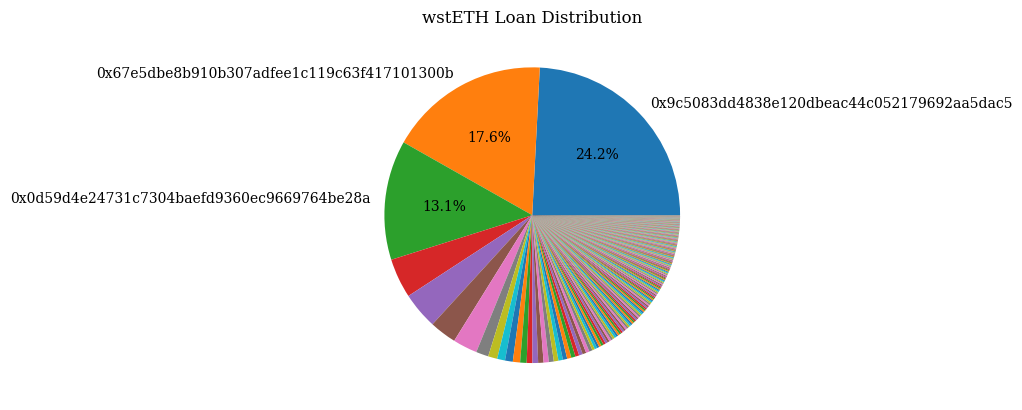

In [5]:
def custom_autopct(pct):
    return "{:.1f}%".format(pct) if pct > 5 else ""


controller = scenario.controller
total_debt = 0
loans = {}
for user, loan in controller.loan.items():
    debt = loan.initial_debt / 1e18
    loans[user] = debt
    total_debt += debt

thresh = 0.05 * total_debt
loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
labels = [a if loans[a] > thresh else "" for a in loans.keys()]
f, ax = plt.subplots()
pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [6]:
for sample in scenario.pricepaths:
    scenario.prepare_for_trades(sample)  # update prices/timestamps
    scenario.perform_actions(sample)  # arbitrage, liquidate, update
    processor.update(sample.timestamp, inplace=True)  # collect metrics

In [7]:
results = processor.process()

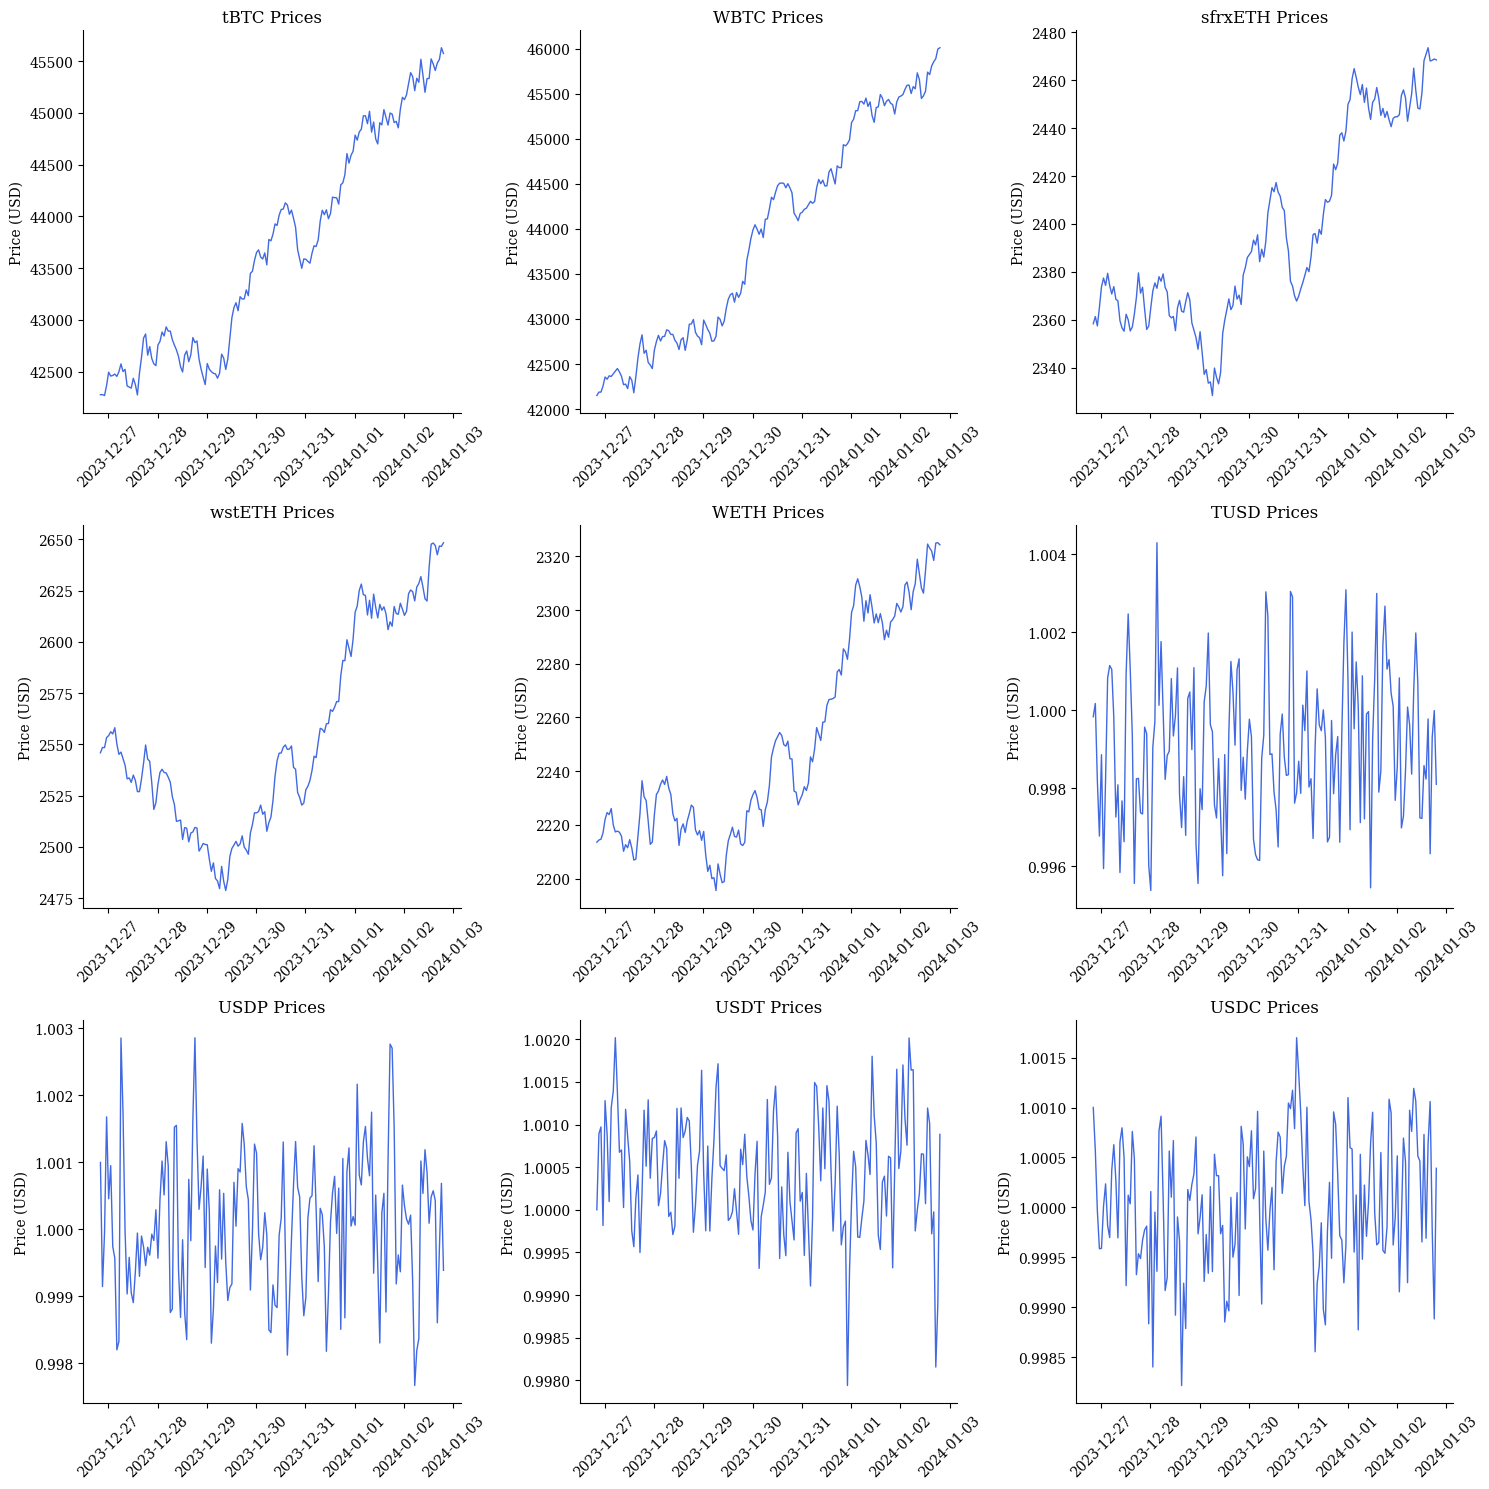

In [8]:
results.plot_prices()

In [9]:
df = results.df
# df.to_csv("../data/results.csv")
df.tail()

,arbitrageur_profit,arbitrageur_volume,arbitrageur_count,liquidator_profit,liquidator_volume,liquidator_count,keeper_profit,keeper_volume,keeper_count,borrower_profit,borrower_volume,borrower_count,liquidityprovider_profit,liquidityprovider_volume,liquidityprovider_count,aggregator_price,controller_wstETH_system_health,controller_wstETH_bad_debt,controller_wstETH_num_loans,controller_wstETH_total_debt,controller_wstETH_users_to_liquidate,llamma_wstETH_price,llamma_wstETH_oracle_price,llamma_wstETH_fees_x,llamma_wstETH_fees_y,llamma_wstETH_bal_x,llamma_wstETH_bal_y,pk_crvUSD/TUSD_debt,pk_crvUSD/TUSD_profit,pk_crvUSD/USDP_debt,pk_crvUSD/USDP_profit,pk_crvUSD/USDC_debt,pk_crvUSD/USDC_profit,pk_crvUSD/USDT_debt,pk_crvUSD/USDT_profit,stablecoin_total_supply,stableswap_crvUSD_TUSD_price,stableswap_crvUSD_TUSD_ma_price,stableswap_crvUSD_TUSD_lp_supply,stableswap_crvUSD_TUSD_virtual_price,stableswap_crvUSD_TUSD_TUSD_bal,stableswap_crvUSD_TUSD_crvUSD_bal,stableswap_crvUSD_USDP_price,stableswap_crvUSD_USDP_ma_price,stableswap_crvUSD_USDP_lp_supply,stableswap_crvUSD_USDP_virtual_price,stableswap_crvUSD_USDP_USDP_bal,stableswap_crvUSD_USDP_crvUSD_bal,stableswap_crvUSD_USDC_price,stableswap_crvUSD_USDC_ma_price,stableswap_crvUSD_USDC_lp_supply,stableswap_crvUSD_USDC_virtual_price,stableswap_crvUSD_USDC_USDC_bal,stableswap_crvUSD_USDC_crvUSD_bal,stableswap_crvUSD_USDT_price,stableswap_crvUSD_USDT_ma_price,stableswap_crvUSD_USDT_lp_supply,stableswap_crvUSD_USDT_virtual_price,stableswap_crvUSD_USDT_USDT_bal,stableswap_crvUSD_USDT_crvUSD_bal
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-02 15:12:17,164400.287347,0,507,3706.034759,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.998962,0.577608,0.0,311,3.460752e+07,1,2666.103673,2647.021235,5974,0,489704.053551,23066.138034,73333.405378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.412827e+08,1.000224,1.000225,4.348282e+06,1.000865,2.297607e+06,2.054448e+06,0.998991,0.998991,4.142072e+06,1.000571,1.600908e+06,2.543757e+06,0.998676,0.998686,3.479165e+07,1.000208,0.000013,2.230084e+07,0.999391,0.999225,2.895259e+07,1.000232,0.000012,1.659717e+07
2024-01-02 16:12:17,165520.591772,0,511,3706.034759,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.998979,0.574711,0.0,311,3.460815e+07,1,2652.426682,2642.505077,5974,0,489704.053551,23066.138034,73333.405378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.426053e+08,1.002342,1.001976,4.348282e+06,1.000874,3.064225e+06,1.288722e+06,1.000165,1.000072,4.142072e+06,1.000578,2.157599e+06,1.986875e+06,0.998186,0.998413,3.479165e+07,1.000209,0.000011,2.349793e+07,0.999351,0.999364,2.895259e+07,1.000233,0.000012,1.672262e+07
2024-01-02 17:12:17,167318.950729,0,514,3706.034759,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.998921,0.577393,0.0,311,3.460878e+07,1,2665.183650,2646.779923,5974,0,489704.053551,23066.138034,73333.405378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.444236e+08,0.999413,0.999786,4.348282e+06,1.000887,1.868685e+06,2.483543e+06,0.998810,0.998830,4.142072e+06,1.000586,1.534407e+06,2.610390e+06,0.998265,0.998267,3.479165e+07,1.000210,0.000011,2.332485e+07,0.999835,0.999654,2.895259e+07,1.000235,0.000014,1.507727e+07
2024-01-02 18:12:17,168704.224924,0,518,3706.034759,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.999063,0.577258,0.0,311,3.460941e+07,1,2664.588591,2646.614376,5974,0,489704.053551,23066.138034,73333.405378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.468626e+08,0.998693,0.998865,4.348282e+06,1.000891,1.569323e+06,2.783199e+06,0.997753,0.997770,4.142072e+06,1.000589,1.245705e+06,2.899591e+06,0.999133,0.998944,3.479165e+07,1.000213,0.000014,2.088572e+07,0.999285,0.999291,2.895259e+07,1.000239,0.000012,1.692742e+07
2024-01-02 19:12:17,170483.798156,0,521,3706.034759,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.999144,0.578358,0.0,311,3.461004e+07,1,2669.865699,2648.397990,5974,0,489704.053551,23066.138034,73333.405378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.484899e+08,1.000770,1.000161,4.348282e+06,1.000902,2.569112e+06,1.783239e+06,0.999608,0.999579,4.142072e+06,1.000597,1.872439e+06,2.272144e+06,0.999133,0.999130,3.479165e+07,1.000213,0.000014,2.088572e

In [10]:
results.metric_map

{'AgentMetrics': 0,
 'AggregatorMetrics': 1,
 'ControllerMetrics': 2,
 'LLAMMAMetrics': 3,
 'PegKeeperMetrics': 4,
 'StablecoinMetrics': 5,
 'StableSwapMetrics': 6}

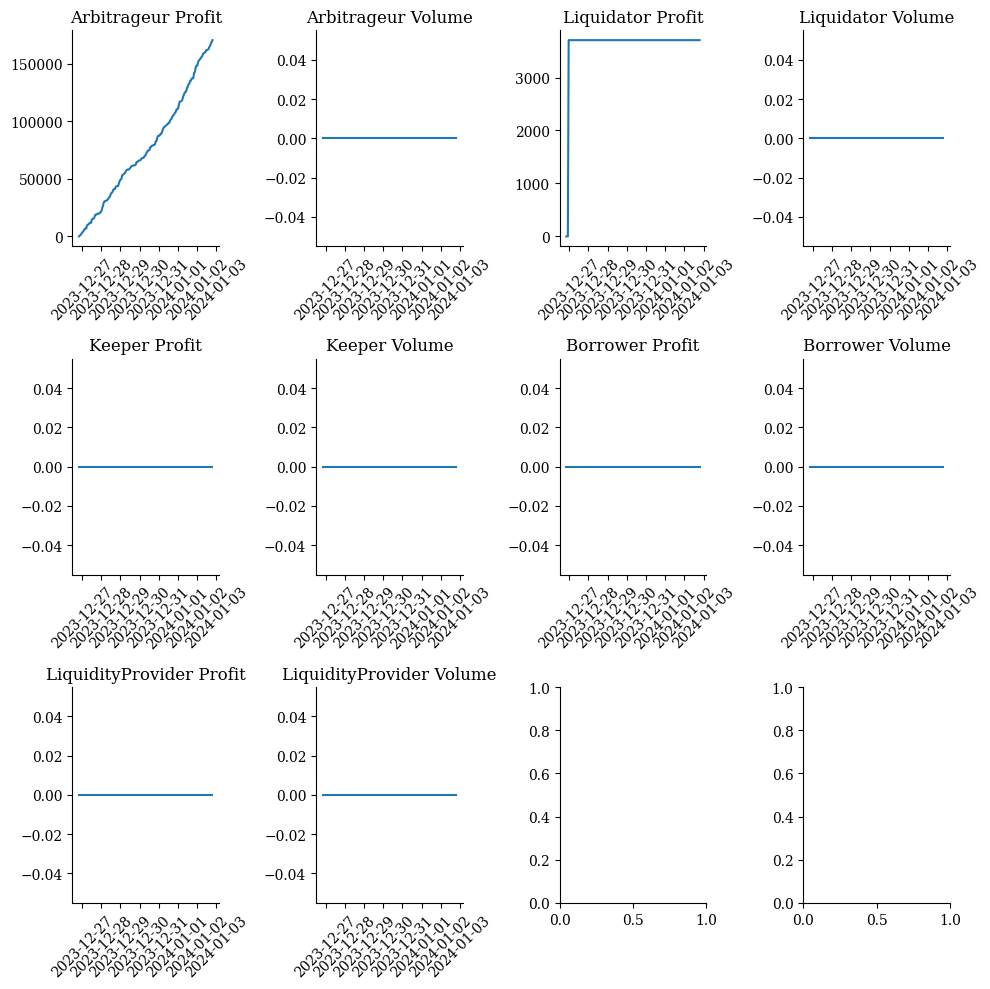

array([[<Axes: title={'center': 'Arbitrageur Profit'}>,
        <Axes: title={'center': 'Arbitrageur Volume'}>,
        <Axes: title={'center': 'Liquidator Profit'}>,
        <Axes: title={'center': 'Liquidator Volume'}>],
       [<Axes: title={'center': 'Keeper Profit'}>,
        <Axes: title={'center': 'Keeper Volume'}>,
        <Axes: title={'center': 'Borrower Profit'}>,
        <Axes: title={'center': 'Borrower Volume'}>],
       [<Axes: title={'center': 'LiquidityProvider Profit'}>,
        <Axes: title={'center': 'LiquidityProvider Volume'}>, <Axes: >,
        <Axes: >]], dtype=object)

In [11]:
results.plot_metric(0, show=True)

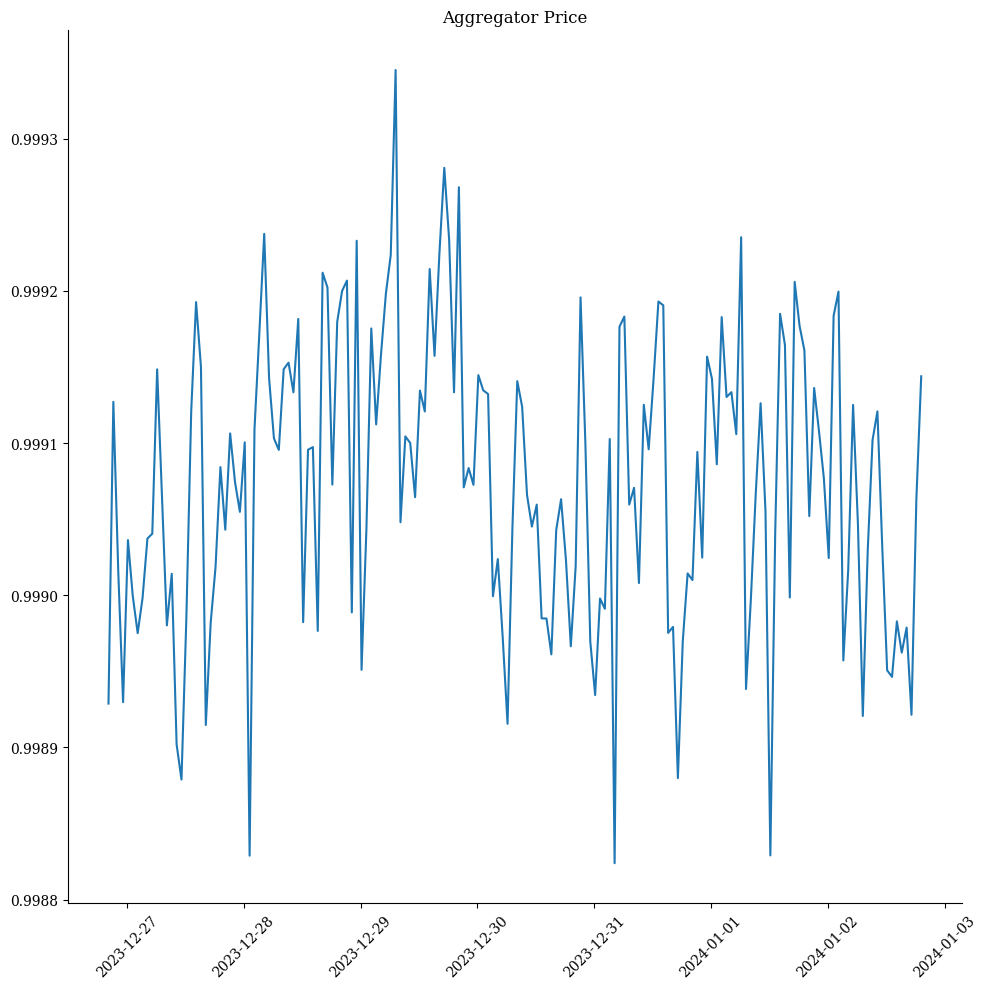

<Axes: title={'center': 'Aggregator Price'}>

In [20]:
results.plot_metric(1, show=True)

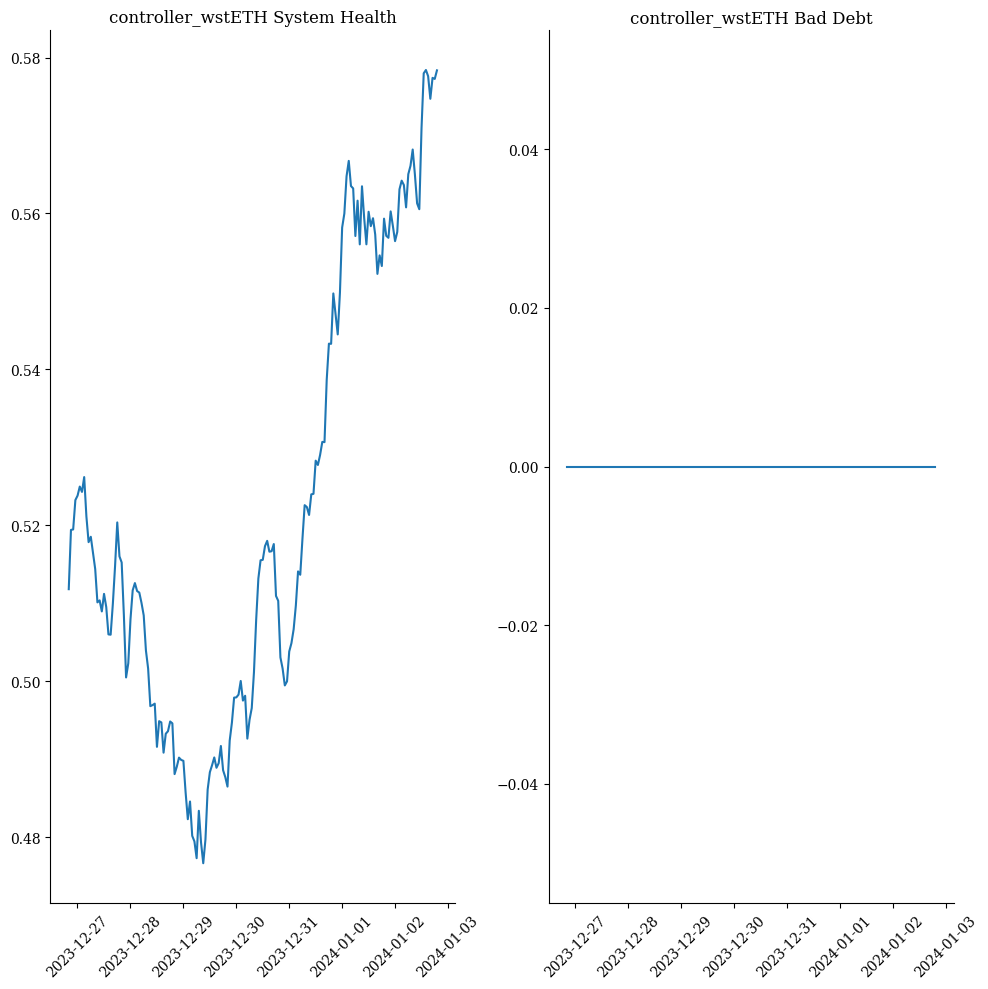

array([<Axes: title={'center': 'controller_wstETH System Health'}>,
       <Axes: title={'center': 'controller_wstETH Bad Debt'}>],
      dtype=object)

In [21]:
results.plot_metric(2, show=True)

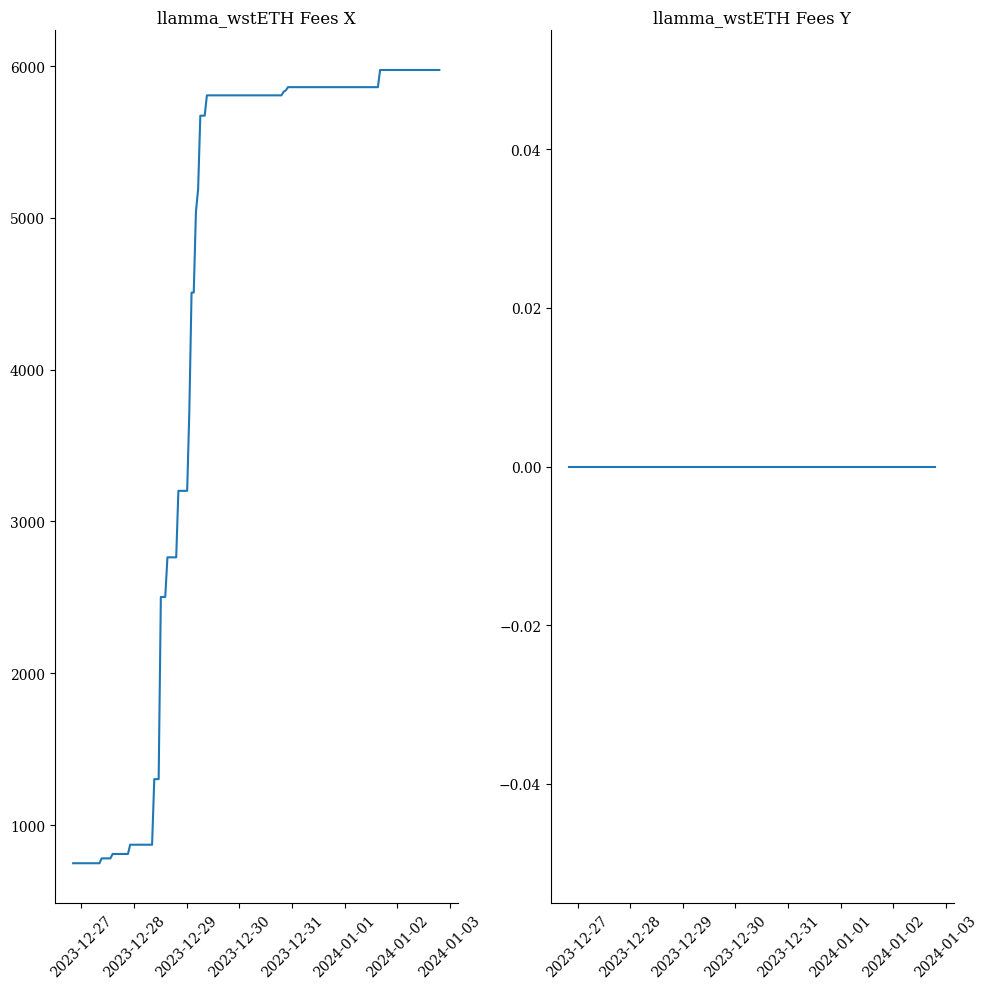

array([<Axes: title={'center': 'llamma_wstETH Fees X'}>,
       <Axes: title={'center': 'llamma_wstETH Fees Y'}>], dtype=object)

In [22]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

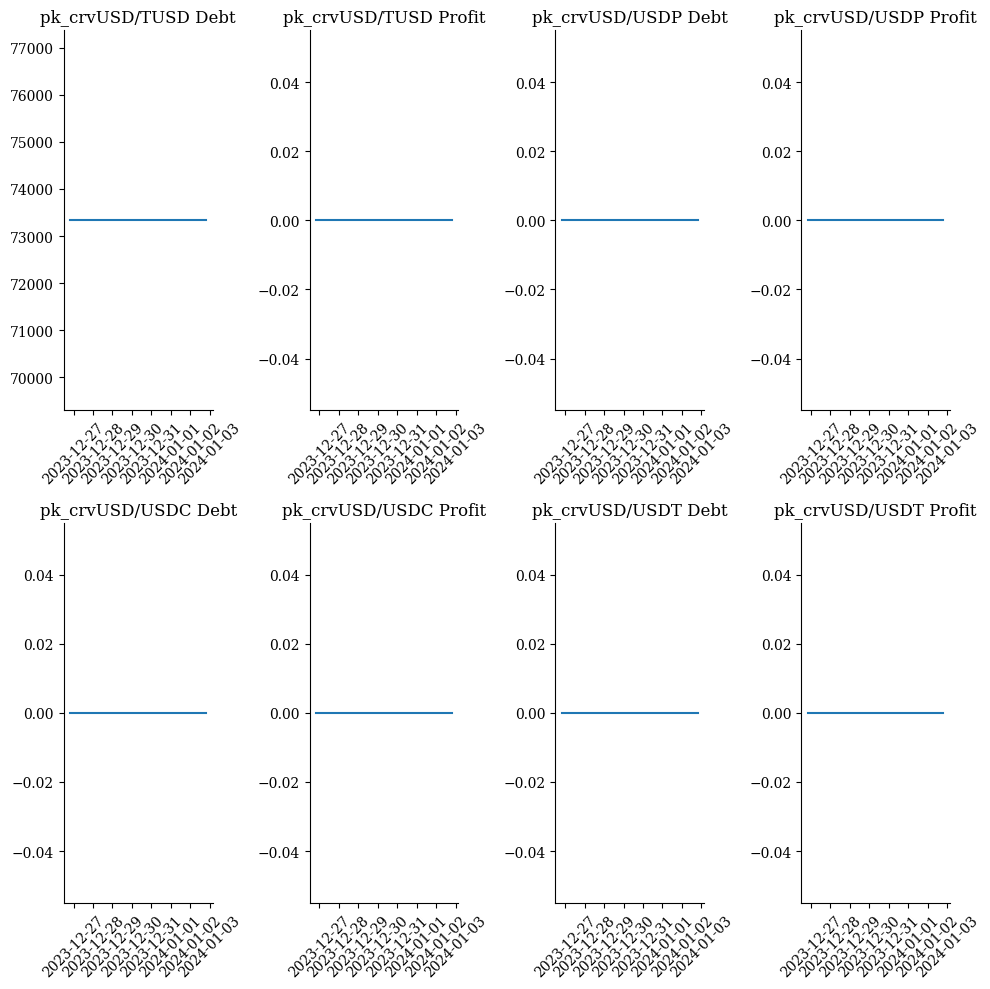

array([[<Axes: title={'center': 'pk_crvUSD/TUSD Debt'}>,
        <Axes: title={'center': 'pk_crvUSD/TUSD Profit'}>,
        <Axes: title={'center': 'pk_crvUSD/USDP Debt'}>,
        <Axes: title={'center': 'pk_crvUSD/USDP Profit'}>],
       [<Axes: title={'center': 'pk_crvUSD/USDC Debt'}>,
        <Axes: title={'center': 'pk_crvUSD/USDC Profit'}>,
        <Axes: title={'center': 'pk_crvUSD/USDT Debt'}>,
        <Axes: title={'center': 'pk_crvUSD/USDT Profit'}>]], dtype=object)

In [23]:
results.plot_metric(4, show=True)

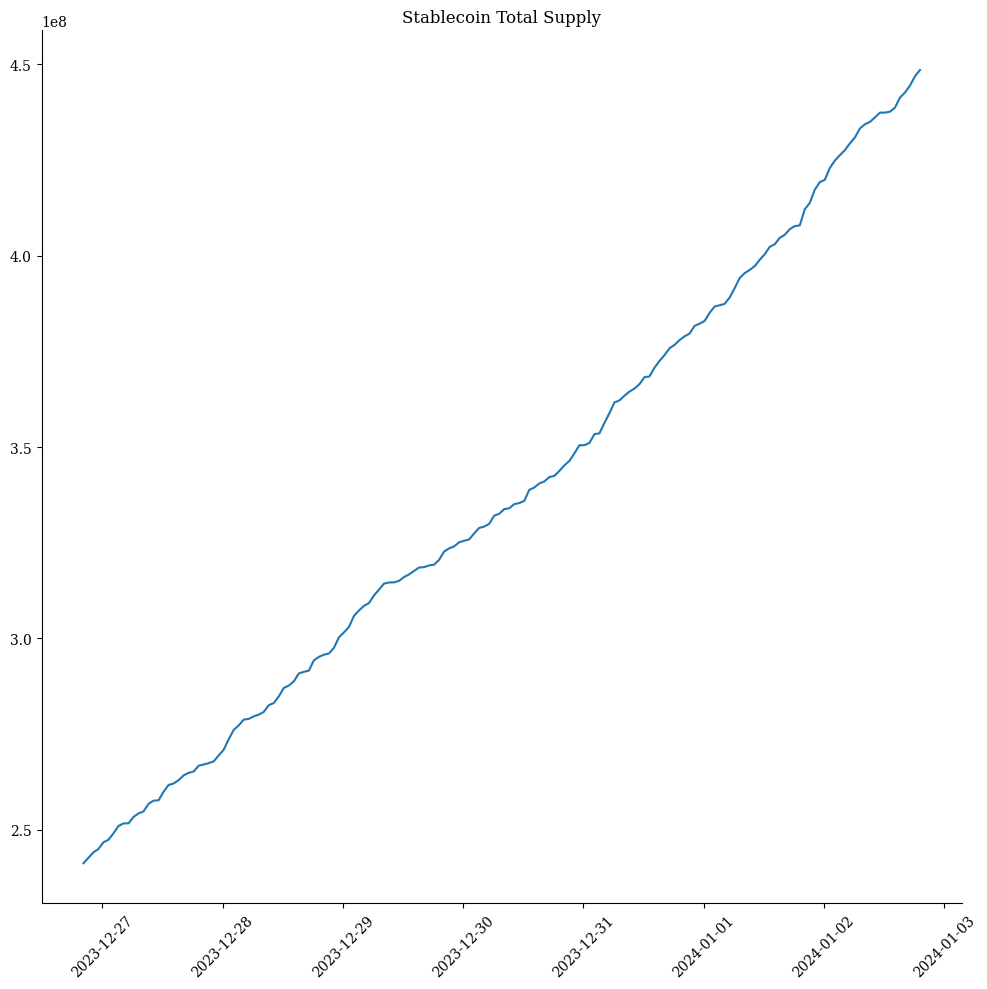

<Axes: title={'center': 'Stablecoin Total Supply'}>

In [24]:
results.plot_metric(5, show=True)

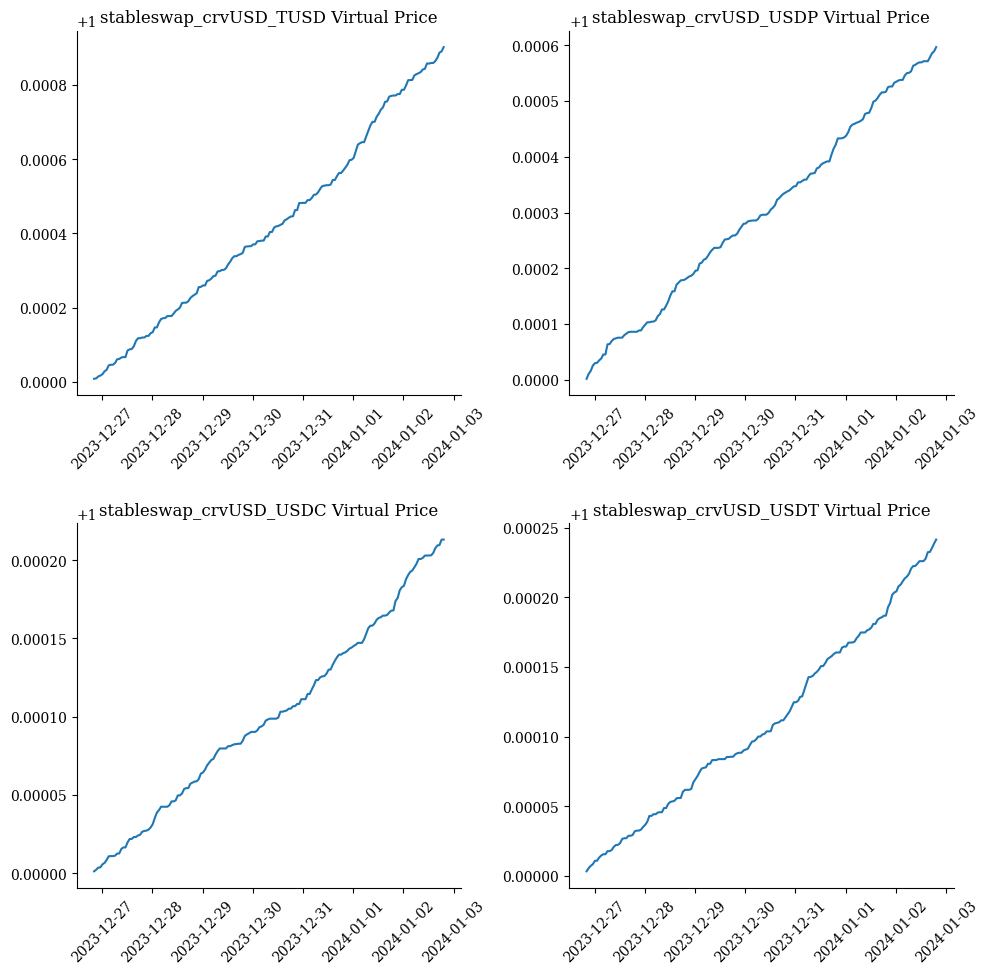

array([[<Axes: title={'center': 'stableswap_crvUSD_TUSD Virtual Price'}>,
        <Axes: title={'center': 'stableswap_crvUSD_USDP Virtual Price'}>],
       [<Axes: title={'center': 'stableswap_crvUSD_USDC Virtual Price'}>,
        <Axes: title={'center': 'stableswap_crvUSD_USDT Virtual Price'}>]],
      dtype=object)

In [25]:
results.plot_metric(6, show=True)

In [26]:
summary = results.summary.T
summary.columns = ["value"]
summary

,value
arbitrageur_profit_max,1.704838e+05
arbitrageur_volume_max,0.000000e+00
liquidator_profit_max,3.706035e+03
liquidator_volume_max,0.000000e+00
keeper_profit_max,0.000000e+00
keeper_volume_max,0.000000e+00
borrower_profit_max,0.000000e+00
borrower_volume_max,0.000000e+00
liquidityprovider_profit_max,0.000000e+00
liquidityprovider_volume_max,0.000000e+00
